In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

##import lightgbm as lgb
##from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 2
np.random.seed(SEED)

In [16]:
# renaming columns
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [18]:
train= pd.read_csv('C:/Users/user/energy/energy/train.csv', encoding = 'cp949',  names=train_col, header=0)
test = pd.read_csv('C:/Users/user/energy/energy/test.csv', encoding = 'cp949', names=test_col, header=0)
sub = pd.read_csv('C:/Users/user/energy/energy/sample_submission.csv', encoding='cp949')

In [19]:
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    
    return train

In [20]:

train = make_time(train)
test = make_time(test)

In [21]:

train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[train.weekday < 5, 'holiday'] = 0
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = 1

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0

In [22]:
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

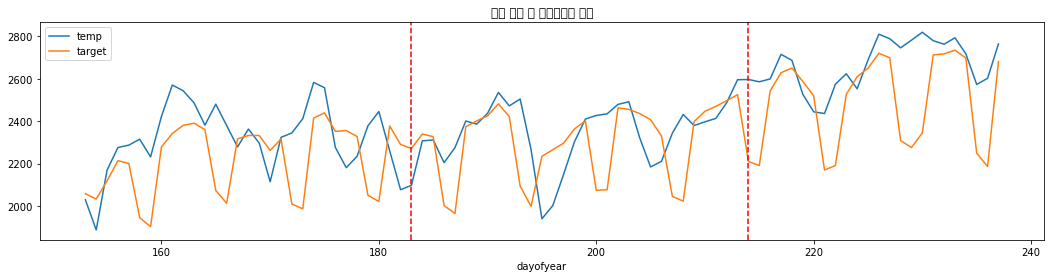

In [23]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

In [24]:
train.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,0.0


In [25]:
test.head()

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0.0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,1,1,238,0.0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,2,1,238,0.0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,0.0,0.0,8,25,3,1,238,0.0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,4,1,238,0.0


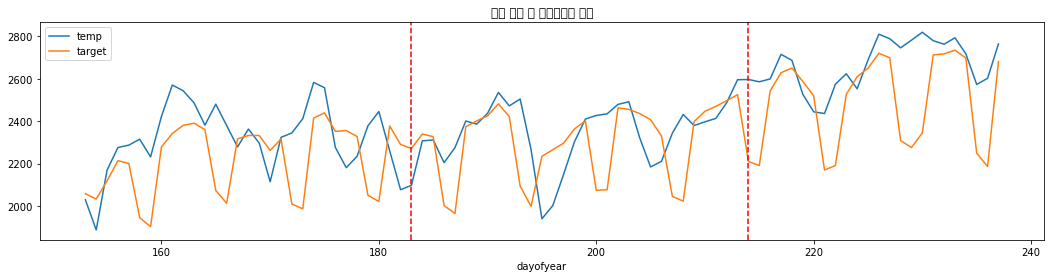

In [26]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

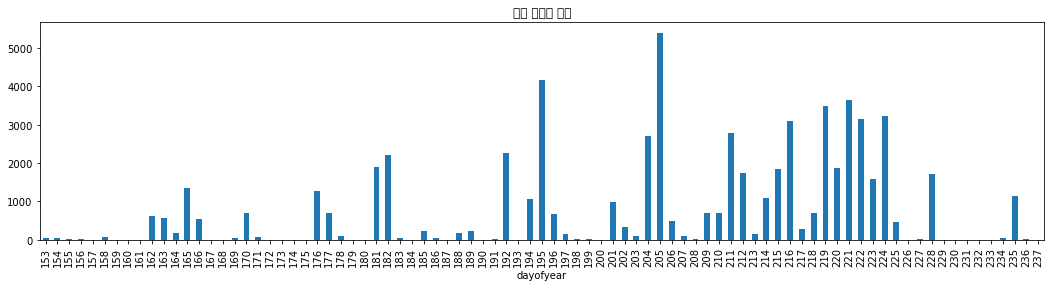

In [27]:
(train.groupby(['dayofyear'])['rain'].sum()).plot(kind='bar', figsize=(18, 4))
plt.title('일별 강수량 추이')
plt.show()

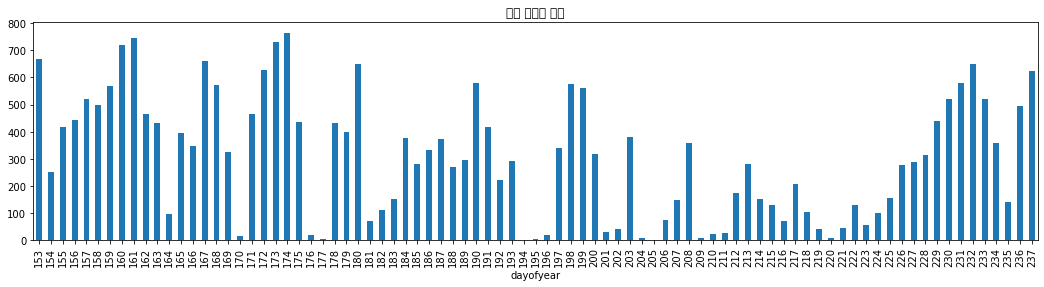

In [28]:
train.groupby(['dayofyear'])['sunny'].sum().plot(kind='bar', figsize=(18, 4))
plt.title('일별 일조량 추이')
plt.show()

In [36]:
train_origin = train.copy()

In [37]:
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean()
    std_ = train.loc[train.num == i].target.std()
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [38]:
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [39]:
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [40]:
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [41]:
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

cl_df.columns = columns

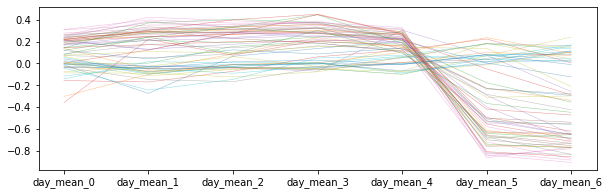

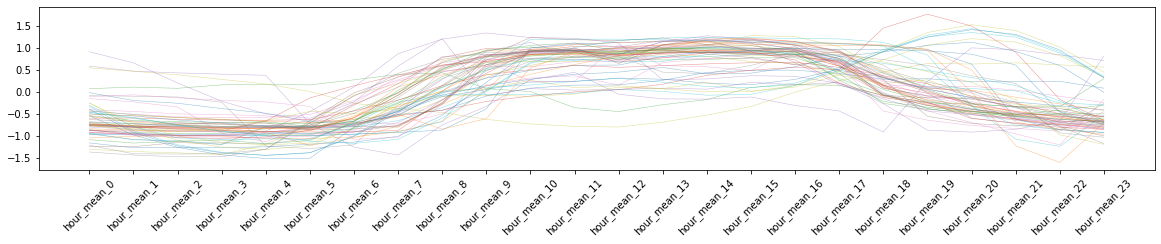

In [42]:
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

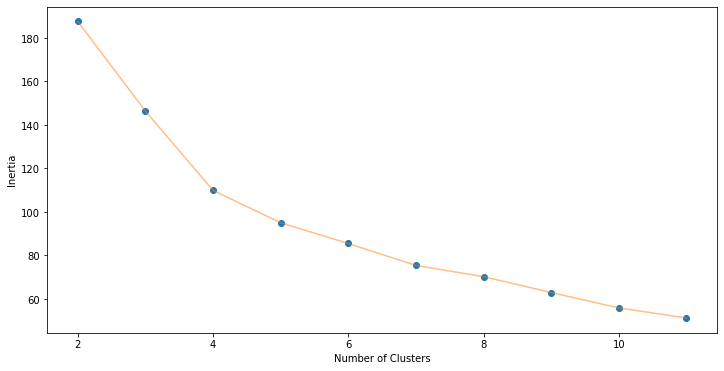

In [43]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

In [44]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [45]:
cl_df['km_cluster'] = pred

In [46]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [47]:
test_cl = test.copy()

In [48]:
for i in range(1, 61):
    test_cl.loc[test_cl.num == i, 'km_cluster'] = (
        train_cl.loc[train_cl.num == i, 'km_cluster'].max()
    )

In [49]:
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

In [50]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

,num
km_cluster,
0,7.0
1,33.0
2,5.0
3,15.0


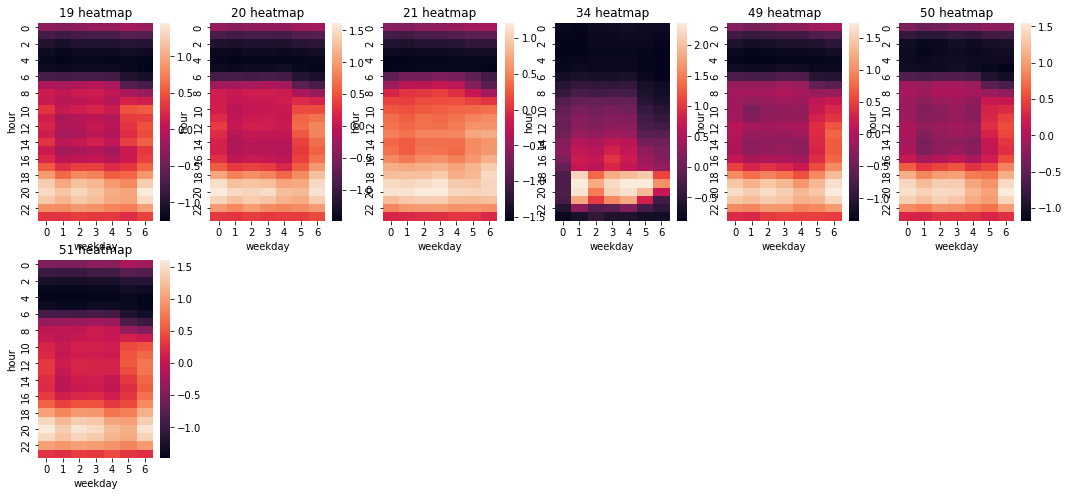

In [51]:
fig = plt.figure(figsize=(18, np.ceil(len(km_0)/6)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/6), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

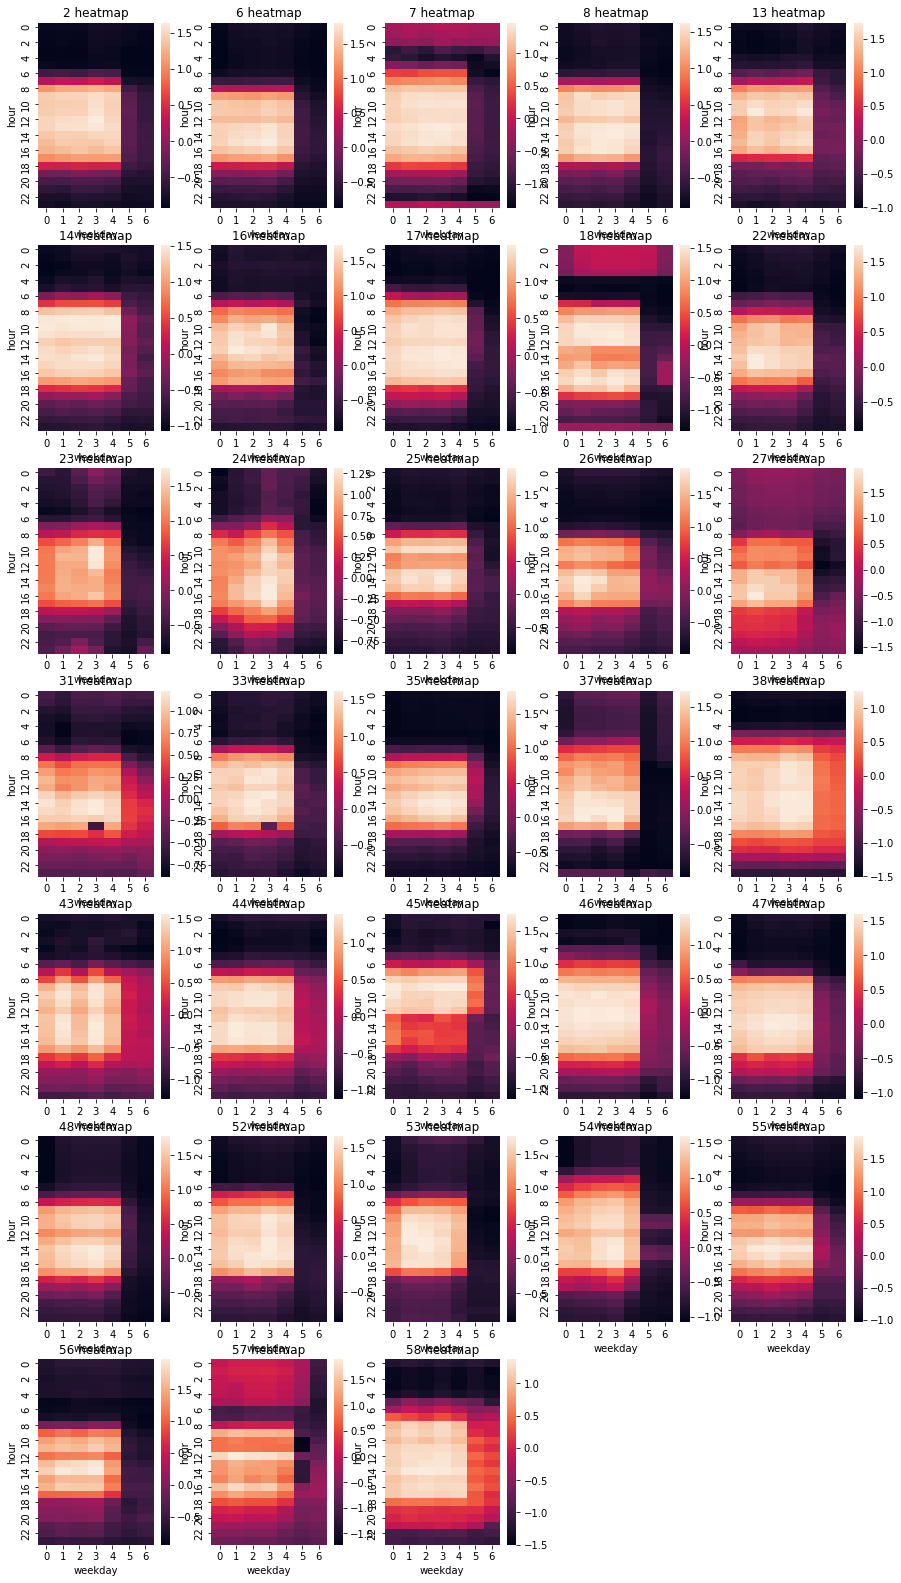

In [53]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

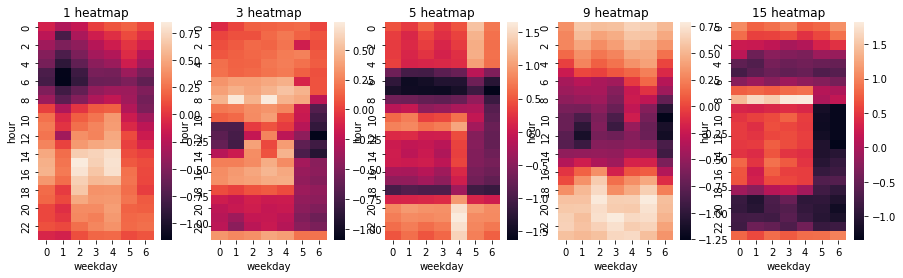

In [54]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

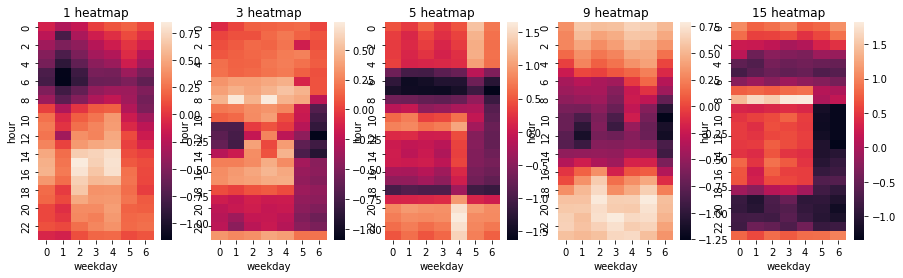

In [55]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

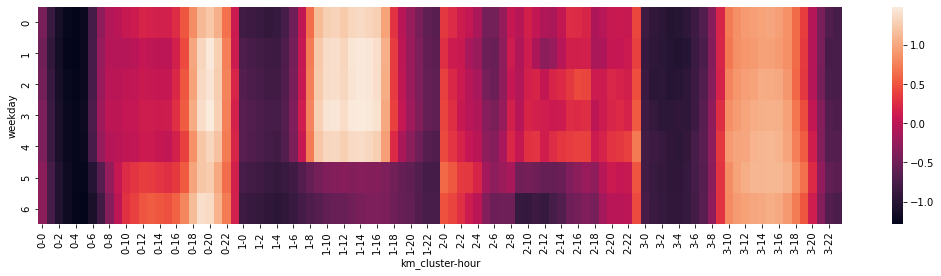

In [56]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [59]:
from scipy.stats import pearsonr

In [60]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

In [61]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [62]:
cl_df['km_cluster'] = pred

In [63]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [64]:
corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()

In [65]:
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [66]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].wind,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [67]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)

### 기온에 영향

In [68]:
corrs_temp_temp = (corrs_cl_temp.temp_corr
                   .reset_index()
                   .sort_values(by=['temp_corr'], ascending=False)
                  .set_index(['num'], drop=False))

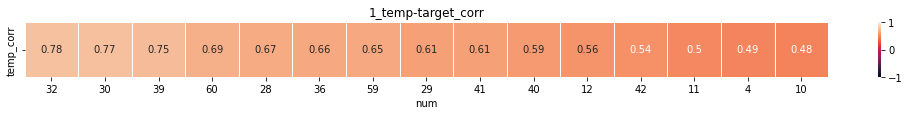

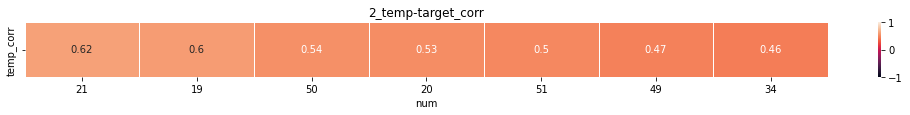

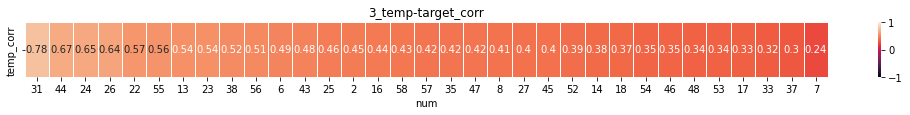

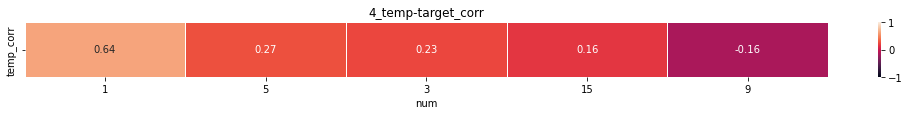

In [69]:
plt.figure(figsize=(18, 1))
plt.title('1_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

### 습도에 영향

In [70]:
corrs_temp_temp = (corrs_cl_temp.humid_corr
                   .reset_index()
                   .sort_values(by=['humid_corr'], ascending=True)
                  .set_index(['num'], drop=False))

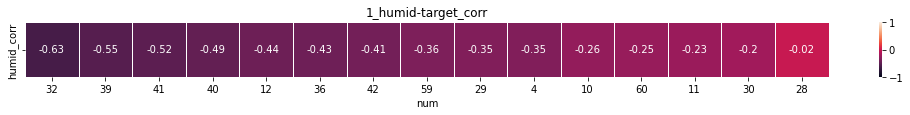

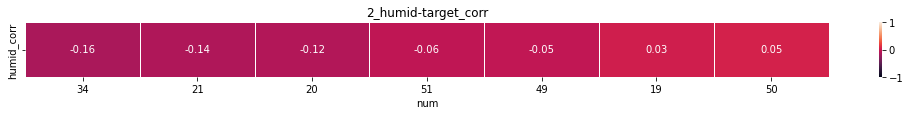

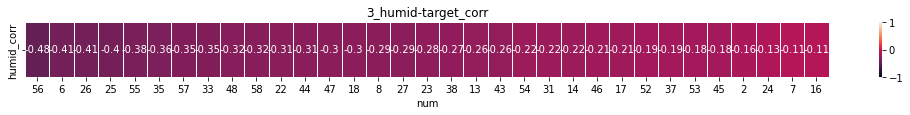

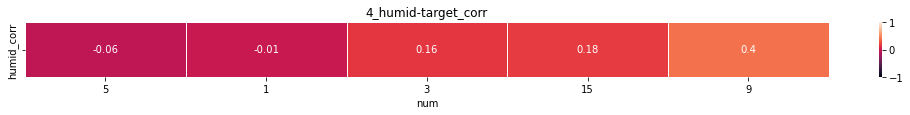

In [71]:
plt.figure(figsize=(18, 1))
plt.title('1_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

### 바람의 영향

In [72]:
corrs_temp_temp = (corrs_cl_temp.wind_corr
                   .reset_index()
                   .sort_values(by=['wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))

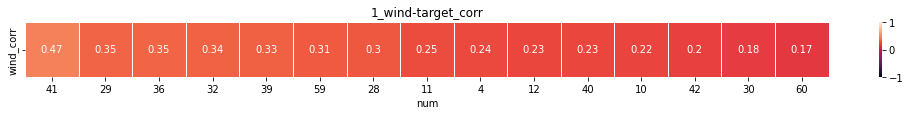

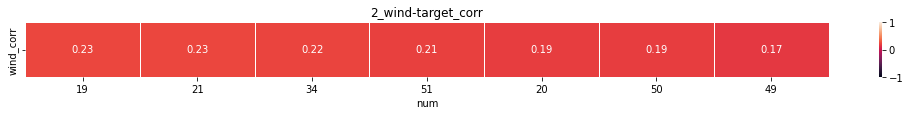

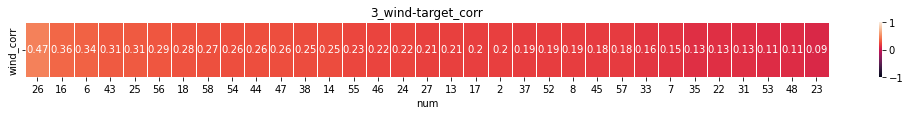

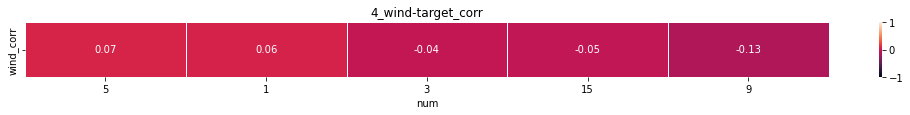

In [73]:
plt.figure(figsize=(18, 1))
plt.title('1_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()